In [3]:
from feature_reader import process_files_randomly, preprocess_data, read_and_process_polars
feature, target = process_files_randomly('processed_data', 4000)
feature, target = preprocess_data(feature, target, feature.columns, target.columns)


In [4]:
feature

slot,cumulative_inflow,cumulative_outflow,Token0,Token1,open_token0,open_token1,open_liquidity,current_token0,current_token1,current_liquidity_ratio,current_to_open_token0_ratio,slot_elapse,token0_value_15slots,token0_relative_value_15slots,token0_diff_value_15slots,token0_relative_diff_value_15slots,inflow_15slots,outflow_15slots,token0_value_30slots,token0_relative_value_30slots,token0_diff_value_30slots,token0_relative_diff_value_30slots,inflow_30slots,outflow_30slots,token0_value_60slots,token0_relative_value_60slots,token0_diff_value_60slots,token0_relative_diff_value_60slots,inflow_60slots,outflow_60slots,token0_value_120slots,token0_relative_value_120slots,token0_diff_value_120slots,token0_relative_diff_value_120slots,inflow_120slots,outflow_120slots,…,holding_entropy_diff_30slots,top_5_address_holding_diff_60slots,top_10_address_holding_diff_60slots,max_address_holding_diff_60slots,holding_entropy_diff_60slots,top_5_address_holding_diff_120slots,top_10_address_holding_diff_120slots,max_address_holding_diff_120slots,holding_entropy_diff_120slots,top_5_address_holding_diff_240slots,top_10_address_holding_diff_240slots,max_address_holding_diff_240slots,holding_entropy_diff_240slots,top_5_address_holding_diff_480slots,top_10_address_holding_diff_480slots,max_address_holding_diff_480slots,holding_entropy_diff_480slots,top_5_address_holding_diff_960slots,top_10_address_holding_diff_960slots,max_address_holding_diff_960slots,holding_entropy_diff_960slots,top_5_address_holding_diff_1920slots,top_10_address_holding_diff_1920slots,max_address_holding_diff_1920slots,holding_entropy_diff_1920slots,top_5_address_holding_diff_3840slots,top_10_address_holding_diff_3840slots,max_address_holding_diff_3840slots,holding_entropy_diff_3840slots,top_5_address_holding_diff_7680slots,top_10_address_holding_diff_7680slots,max_address_holding_diff_7680slots,holding_entropy_diff_7680slots,time_of_day_morning,time_of_day_afternoon,time_of_day_evening,time_of_day_night
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,i8
-1.638852,-0.424033,0.435719,-0.359445,-0.15638,-0.22559,-0.20379,-0.119814,-0.359445,-0.15638,-0.032355,-0.324098,-0.603039,-0.362462,-0.324146,0.264605,0.001108,-0.312157,0.288177,-0.36246,-0.324109,0.210714,-0.001496,-0.399496,0.372253,-0.362407,-0.32406,0.163508,-0.004648,-0.475165,0.449666,-0.362185,-0.323969,0.118648,-0.008852,-0.527911,0.510328,…,-0.133335,-17.675657,-24.056658,-10.630364,-0.166212,-12.473116,-16.249611,-7.964517,-0.220055,-8.706992,-10.897941,-5.978274,-0.267292,-6.082985,-7.406636,-4.428533,-0.327253,-4.342738,-5.187271,-3.292699,-0.404843,-3.188326,-3.773159,-2.476809,-0.51043,-2.365683,-2.79615,-1.847792,-0.663309,-1.785179,-2.131408,-1.369147,-0.886961,0,0,0,1
-1.638813,-0.4238,0.435719,-0.359299,-0.156381,-0.22559,-0.20379,-0.119814,-0.359299,-0.156381,-0.032533,-0.324091,-0.602909,-0.362462,-0.324146,0.277441,0.001477,-0.035573,0.288177,-0.36246,-0.324109,0.221,-0.001195,-0.207808,0.372253,-0.362407,-0.32406,0.171703,-0.004394,-0.355338,0.449666,-0.362185,-0.323969,0.125157,-0.008647,-0.45889,0.510328,…,-0.133335,0.135649,0.139706,0.137552,-0.166212,0.180583,0.181689,0.186665,-0.220055,0.224746,0.222948,0.231692,-0.267292,0.282303,0.276764,0.29427,-0.327253,0.357785,0.347778,0.375627,-0.404843,0.459702,0.444489,0.484206,-0.51043,0.608013,0.585126,0.642471,-0.663309,0.82755,0.792077,0.882785,-0.886961,0,0,0,1
-1.638808,-0.423697,0.435719,-0.357924,-0.156387,-0.22559,-0.20379,-0.119814,-0.357924,-0.156387,-0.032523,-0.324032,-0.602893,-0.362462,-0.324146,0.398325,0.004952,0.087783,0.288177,-0.36246,-0.324109,0.317859,0.00164,-0.122315,0.372253,-0.362407,-0.32406,0.248874,-0.002003,-0.301895,0.449666,-0.362185,-0.323969,0.186453,-0.006712,-0.428107,0.510328,…,3.05788

In [11]:
import polars as pl
target.filter(pl.col('token0_drop_10%_15slots') == 1)

slot,token0_value_15slots,token0_drop_10%_15slots,token0_15slots,token0_changeratio_15slots,token0_drop_15%_15slots,token0_drop_20%_15slots,token0_drop_30%_15slots,token0_drop_40%_15slots,token0_drop_50%_15slots,token0_value_30slots,token0_drop_10%_30slots,token0_30slots,token0_changeratio_30slots,token0_drop_15%_30slots,token0_drop_20%_30slots,token0_drop_30%_30slots,token0_drop_40%_30slots,token0_drop_50%_30slots,token0_value_60slots,token0_drop_10%_60slots,token0_60slots,token0_changeratio_60slots,token0_drop_15%_60slots,token0_drop_20%_60slots,token0_drop_30%_60slots,token0_drop_40%_60slots,token0_drop_50%_60slots,token0_value_120slots,token0_drop_10%_120slots,token0_120slots,token0_changeratio_120slots,token0_drop_15%_120slots,token0_drop_20%_120slots,token0_drop_30%_120slots,token0_drop_40%_120slots,token0_drop_50%_120slots,…,token0_drop_50%_480slots,token0_value_960slots,token0_drop_10%_960slots,token0_960slots,token0_changeratio_960slots,token0_drop_15%_960slots,token0_drop_20%_960slots,token0_drop_30%_960slots,token0_drop_40%_960slots,token0_drop_50%_960slots,token0_value_1920slots,token0_drop_10%_1920slots,token0_1920slots,token0_changeratio_1920slots,token0_drop_15%_1920slots,token0_drop_20%_1920slots,token0_drop_30%_1920slots,token0_drop_40%_1920slots,token0_drop_50%_1920slots,token0_value_3840slots,token0_drop_10%_3840slots,token0_3840slots,token0_changeratio_3840slots,token0_drop_15%_3840slots,token0_drop_20%_3840slots,token0_drop_30%_3840slots,token0_drop_40%_3840slots,token0_drop_50%_3840slots,token0_value_7680slots,token0_drop_10%_7680slots,token0_7680slots,token0_changeratio_7680slots,token0_drop_15%_7680slots,token0_drop_20%_7680slots,token0_drop_30%_7680slots,token0_drop_40%_7680slots,token0_drop_50%_7680slots
i64,f64,i32,f64,f64,i32,i32,i32,i32,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32,…,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32
271645521,-0.363778,1,7.6620e10,-0.112102,0,0,0,0,0,-0.364948,1,7.4697e10,-0.134394,0,0,0,0,0,-0.36491,1,7.4559e10,-0.135996,0,0,0,0,0,-0.36604,1,7.2156e10,-0.163839,1,0,0,0,0,…,0,-0.363565,1,6.8587e10,-0.205192,1,1,0,0,0,-0.390583,1,1.7959e10,-0.791881,1,1,1,1,1,-0.382392,1,1.8325e10,-0.787643,1,1,1,1,1,-0.368362,1,1.7268e10,-0.799897,1,1,1,1,1
271645522,-0.363778,1,7.6620e10,-0.113216,0,0,0,0,0,-0.365771,1,7.3361e10,-0.150936,1,0,0,0,0,-0.36491,1,7.4559e10,-0.13708,0,0,0,0,0,-0.36604,1,7.2156e10,-0.164888,1,0,0,0,0,…,0,-0.363565,1,6.8587e10,-0.20619,1,1,0,0,0,-0.390583,1,1.7959e10,-0.792142,1,1,1,1,1,-0.382392,1,1.8325e10,-0.787909,1,1,1,1,1,-0.368362,1,1.7268e10,-0.800148,1,1,1,1,1
271645523,-0.363778,1,7.6620e10,-0.113473,0,0,0,0,0,-0.3596,0,8.3371e10,-0.035362,0,0,0,0,0,-0.36491,1,7.4559e10,-0.13733,0,0,0,0,0,-0.36604,1,7.2156e10,-0.16513,1,0,0,0,0,…,0,-0.363565,1,6.8587e10,-0.206419,1,1,0,0,0,-0.390583,1,1.7959e10,-0.792203,1,1,1,1,1,-0.382392,1,1.8325e10,-0.78797,1,1,1,1,1,-0.368362,1,1.7268e10,-0.800206,1,1,1,1,1
271645525,-0.363778,1,7.6620e10,-0.148276,0,0,0,0,0,-0.3596,0,8.3371e10,-0.073232,0,0,0,0,0,-0.364756,1,7.4809e10,-0.168417,1,0,0,0,0,-0.36604,1,7.2156e10,-0.197905,1,0,0,0,0,…,0,-0.363565,1,6.8587e10,-0.237573,1,1,0,0,0,-0.390583,1,1.7959e10,-0.80036,1,1,1,1,1,-0.382392,1,1.8325e10,-0.796294,1,1,1,1,1,-0.368362,1,1.7268e10,-0.80805,1,1,1,1,1
271645526,-0.364582,1,7.5316e10,-0.155921,1,0,0,0,0,-0.359477,0,8.3571e10,-0.063403,0,0,0,0,0,-0.364726,1,7.4859e10,-0.161049,1,0,0,0,0,-0.36604,1,7.2156e10,-0.191338,1,0,0,0,0,…,0,-0.363565,1,6.8587e10,-0.231331,1,1,0,0,0,-0.390583,1,1.7959e10,-0.798726,1,1,1,1,1,-0.382392,1,1.8325e10,-0.794627,1,1,1,1,1,-0.368362,1,1.7268e10,-0.806478,1,1,1,1,1
271645527,-0.364582,1,7.5316e10,-0.155997,1,0,0,0,0,-0.359446,0,8.3621e10,-0.062927,0,0,0,0,0,-0.365551,1,7.3519e10,-0.176139,1,0,0,0,0,-0.366344,1,7.1662e10,-0.196946,1,0,0,0,0,…,0,-0.363565,1,6.8587e10,-0.2314

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#from imblearn.over_sampling import SMOTE
import numpy as np
# 处理类别不平衡
#smote = SMOTE(random_state=42)
#features_resampled, target_resampled = smote.fit_resample(features_scaled, target)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(feature, target['token0_drop_10%_15slots'], test_size=0.2, random_state=42)

# 训练随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# 评估模型
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# 特征重要性
importances = model.feature_importances_
feature_names = feature.columns
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

/Users/ekko/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
import polars as pl
feature_with_y = feature.with_columns(target['token0_drop_20%_6slots'])
feature_with_y.filter(pl.col('token0_drop_20%_6slots')==1).mean()


open_token0,open_token1,open_liquidity,current_token0,current_token1,current_liquidity_ratio,current_to_open_token0_ratio,slot_elapse,token0_value_15slots,token0_relative_value_15slots,token0_diff_value_15slots,token0_relative_diff_value_15slots,token0_value_30slots,token0_relative_value_30slots,token0_value_60slots,token0_relative_value_60slots,token0_diff_value_30slots,token0_relative_diff_value_30slots,token0_value_120slots,token0_relative_value_120slots,token0_diff_value_60slots,token0_relative_diff_value_60slots,token0_value_240slots,token0_relative_value_240slots,token0_diff_value_120slots,token0_relative_diff_value_120slots,token0_value_480slots,token0_relative_value_480slots,token0_diff_value_240slots,token0_relative_diff_value_240slots,token0_value_960slots,token0_relative_value_960slots,token0_diff_value_480slots,token0_relative_diff_value_480slots,token0_value_1920slots,token0_relative_value_1920slots,token0_diff_value_960slots,…,top_10_address_holding,holding_entropy,top_5_address_holding_diff_15slots,top_10_address_holding_diff_15slots,max_address_holding_diff_15slots,top_5_address_holding_diff_30slots,top_10_address_holding_diff_30slots,max_address_holding_diff_30slots,top_5_address_holding_diff_60slots,top_10_address_holding_diff_60slots,max_address_holding_diff_60slots,top_5_address_holding_diff_120slots,top_10_address_holding_diff_120slots,max_address_holding_diff_120slots,top_5_address_holding_diff_240slots,top_10_address_holding_diff_240slots,max_address_holding_diff_240slots,top_5_address_holding_diff_480slots,top_10_address_holding_diff_480slots,max_address_holding_diff_480slots,top_5_address_holding_diff_960slots,top_10_address_holding_diff_960slots,max_address_holding_diff_960slots,top_5_address_holding_diff_1920slots,top_10_address_holding_diff_1920slots,max_address_holding_diff_1920slots,top_5_address_holding_diff_3840slots,top_10_address_holding_diff_3840slots,max_address_holding_diff_3840slots,top_5_address_holding_diff_7680slots,top_10_address_holding_diff_7680slots,max_address_holding_diff_7680slots,time_of_day_morning,time_of_day_afternoon,time_of_day_evening,time_of_day_night,token0_drop_20%_6slots
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.254604,-0.054543,-0.064167,-0.310865,-0.044114,-0.229279,-0.232808,-0.130078,-0.295218,-0.227668,-0.06048,-0.02494,-0.29572,-0.228081,-0.296792,-0.228154,-0.090181,-0.000601,-0.300108,-0.22844,-0.200725,-0.005923,-0.307151,-0.230539,-0.332044,-0.043471,-0.316307,-0.231357,-0.333236,-0.006783,-0.321603,-0.232007,-0.144132,0.004686,-0.321174,-0.230004,0.012204,…,0.15293,-0.313668,-0.359198,-0.356889,-0.297966,-0.222074,-0.325309,-0.182362,-0.197638,-0.25128,-0.10665,-0.322464,-0.409306,-0.155164,-0.231783,-0.281465,-0.181131,-0.144802,-0.213209,-0.099897,-0.014774,-0.017214,-0.013699,0.088397,0.111185,0.026156,0.09602,0.105788,0.047658,0.090654,0.103835,0.094126,0.492669,0.211144,0.046921,0.249267,1.0


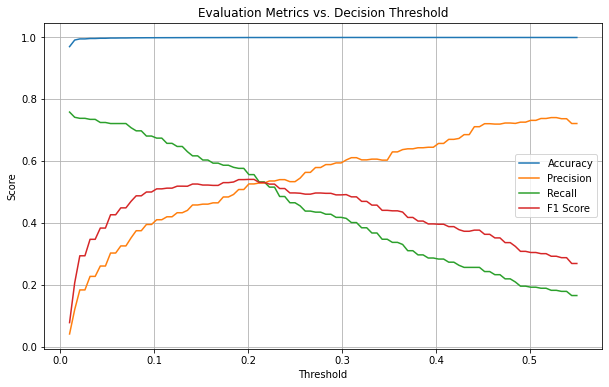

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 假设y_test和预测概率已经计算好
y = y_test
predict_y = model.predict_proba(X_test)[:, 1]

# 存储不同阈值下的指标
thresholds = np.linspace(0.01, 0.55, 100)
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# 计算不同阈值下的指标
for optimal in thresholds:
    y_pred_optimal = (predict_y >= optimal).astype(int)
    accuracy_optimal = accuracy_score(y, y_pred_optimal)
    precision_optimal = precision_score(y, y_pred_optimal)
    recall_optimal = recall_score(y, y_pred_optimal)
    f1_optimal = f1_score(y, y_pred_optimal)
    
    accuracy_list.append(accuracy_optimal)
    precision_list.append(precision_optimal)
    recall_list.append(recall_optimal)
    f1_list.append(f1_optimal)

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_list, label='Accuracy')
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.plot(thresholds, f1_list, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs. Decision Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
predict_y[predict_y==1].shape

(1144,)

In [31]:
y[y == 1].shape

(1364,)

In [47]:
feature.columns

['open_token0',
 'open_token1',
 'open_liquidity',
 'current_token0',
 'current_token1',
 'current_liquidity_ratio',
 'current_to_open_token0_ratio',
 'slot_elapse',
 'token0_value_15slots',
 'token0_relative_value_15slots',
 'token0_diff_value_15slots',
 'token0_relative_diff_value_15slots',
 'token0_value_30slots',
 'token0_relative_value_30slots',
 'token0_value_60slots',
 'token0_relative_value_60slots',
 'token0_diff_value_30slots',
 'token0_relative_diff_value_30slots',
 'token0_value_120slots',
 'token0_relative_value_120slots',
 'token0_diff_value_60slots',
 'token0_relative_diff_value_60slots',
 'token0_value_240slots',
 'token0_relative_value_240slots',
 'token0_diff_value_120slots',
 'token0_relative_diff_value_120slots',
 'token0_value_480slots',
 'token0_relative_value_480slots',
 'token0_diff_value_240slots',
 'token0_relative_diff_value_240slots',
 'token0_value_960slots',
 'token0_relative_value_960slots',
 'token0_diff_value_480slots',
 'token0_relative_diff_value_480s

In [48]:
pl.read_parquet('1XXZVgHFf6suGZ4Je5x7Rz67gHFA6PjSMLpEofz4wB4.parquet').columns

['From', 'Token0', 'Token1', 'Delta0', 'Delta1', 'slot']

In [49]:
feature.shape

(862900, 106)

In [58]:
import collections
import numpy as np
from scipy.stats import entropy
from datetime import datetime, timedelta
import polars as pl
import os
class FeatureExtractor:
    def __init__(self, file_creation_time, window_size=7681):
        self.window_size = window_size
        self.token0_values = collections.deque(maxlen=window_size)
        self.total_inflow = collections.deque(maxlen=window_size)
        self.total_outflow = collections.deque(maxlen=window_size)
        self.top5_holdings = collections.deque(maxlen=window_size)
        self.top10_holdings = collections.deque(maxlen=window_size)
        self.max_holdings = collections.deque(maxlen=window_size)
        self.holding_entropies = collections.deque(maxlen=window_size)
        self.address_holdings = collections.defaultdict(float)
        self.current_slot = None
        self.current_inflow = 0
        self.current_outflow = 0
        self.current_token0 = 0
        self.current_token1 = 0
        self.open_token0 = None
        self.open_token1 = None
        self.open_liquidity = None
        self.open_time = None
        self.start_slot = None
        self.inslot_order = {}
        self.file_creation_time = file_creation_time
        self.prev_slot = None

    def on_slot(self, slot):
        if self.current_slot != slot and self.current_slot is not None:
            # Update for the current slot
            slot_inflow = 0
            slot_outflow = 0
            for from_addr, delta in self.inslot_order.items():
                self.address_holdings[from_addr] += delta
                if delta > 0:
                    slot_inflow += delta
                else:
                    slot_outflow += delta
            self.current_inflow += slot_inflow
            self.current_outflow += slot_outflow
            self.inslot_order = {}
            for s in range(self.current_slot, slot):
                self._append_current_slot_data()
        self.prev_slot = self.current_slot
        self.current_slot = slot

    def update(self, slot, token0, token1, delta0, delta1, from_address):
        # Initialize opening values on the first slot
        if self.open_token0 is None:
            self.open_token0 = token0
            self.open_token1 = token1
            self.open_liquidity = token0 * token1
            self.start_slot = slot
            self.prev_slot = slot

        if self.current_slot != slot and self.current_slot is not None:
            # Update for the current slot
            slot_inflow = 0
            slot_outflow = 0
            for from_addr, delta in self.inslot_order.items():
                self.address_holdings[from_addr] += delta
                if delta > 0:
                    slot_inflow += delta
                else:
                    slot_outflow += delta
            self.current_inflow += slot_inflow
            self.current_outflow += slot_outflow
            self.inslot_order = {}
            for s in range(self.current_slot, slot):
                self._append_current_slot_data()
            self.prev_slot = self.current_slot
        self.current_slot = slot
        self.current_token0 = token0 + delta0
        self.current_token1 = token1 + delta1
        # Update address holdings
        if from_address not in self.inslot_order:
            self.inslot_order[from_address] = 0
        self.inslot_order[from_address] += delta0

    def _append_current_slot_data(self):
        self.token0_values.append(self.current_token0)
        self.total_inflow.append(self.current_inflow)
        self.total_outflow.append(self.current_outflow)

        positive_holdings = [h for h in self.address_holdings.values() if h > 0]
        total_token0 = sum(positive_holdings)

        sorted_holdings = sorted(positive_holdings, reverse=True)
        top5_holding = sum(sorted_holdings[:5]) / total_token0 if total_token0 > 0 else 0
        top10_holding = sum(sorted_holdings[:10]) / total_token0 if total_token0 > 0 else 0
        max_holding = sorted_holdings[0] / total_token0
        self.top5_holdings.append(top5_holding)
        self.top10_holdings.append(top10_holding)
        self.max_holdings.append(max_holding)
        
        holding_distribution = np.array(positive_holdings) / total_token0 if total_token0 > 0 else np.array([0])
        self.holding_entropies.append(entropy(holding_distribution))

    def compute_features(self, past_slot=0):
        # past_slot: skip num of slots
        features = {}
        features['slot'] = self.prev_slot
        features['open_token0'] = self.open_token0
        features['open_token1'] = self.open_token1
        features['open_liquidity'] = self.open_liquidity
        features['cumulative_inflow'] = self.current_inflow
        features['cumulative_outflow'] = self.current_outflow
        features['current_token0'] = self.current_token0
        features['current_token1'] = self.current_token1
        current_liquidity = self.current_token0 * self.current_token1
        features['current_liquidity_ratio'] = current_liquidity / self.open_liquidity if self.open_liquidity else 0
        features['current_to_open_token0_ratio'] = self.current_token0 / self.open_token0 if self.open_token0 else 0
        features['slot_elapse'] = self.prev_slot - self.start_slot

        slot_windows = [15, 30, 60, 120, 240, 480, 960, 1920, 3840, 7680]
        for window in slot_windows:
            window_token0 = self.token0_values[-window-past_slot-1] if len(self.token0_values) > window+past_slot else self.open_token0
            features[f'token0_value_{window}slots'] = window_token0
            features[f'token0_relative_value_{window}slots'] = window_token0 / self.open_token0 if self.open_token0 != 0 else 0
            features[f'token0_diff_value_{window}slots'] = self.token0_values[-past_slot-1] - window_token0
            features[f'token0_relative_diff_value_{window}slots'] = (self.token0_values[-past_slot-1] - window_token0) / self.open_token0 if self.open_token0 != 0 else 0

            window_inflow = self.total_inflow[-window-past_slot-1] if len(self.total_inflow) > window+past_slot else 0
            window_outflow = self.total_outflow[-window-past_slot-1] if len(self.total_outflow) > window+past_slot else 0
            features[f'inflow_{window}slots'] = self.total_inflow[-past_slot-1] - window_inflow
            features[f'outflow_{window}slots'] = self.total_outflow[-past_slot-1] - window_outflow
        # flow diff
        for window in slot_windows[:-1]:
            features[f'inflow_diff_{window}slots'] = 2 * features[f'inflow_{window}slots'] - features[f'inflow_{2 * window}slots']
        
        positive_holdings = [h for h in self.address_holdings.values() if h > 0]
        total_token0 = sum(positive_holdings)
        address_proportions = [v / total_token0 for v in positive_holdings]

        features['negative_holdings'] = sum(h for h in self.address_holdings.values() if h < 0)
        features['num_addresses'] = len(positive_holdings)
        features['max_address_holding'] = max(positive_holdings) / total_token0 if total_token0 > 0 else 0
        features['top_5_address_holding'] = sum(sorted(positive_holdings, reverse=True)[:5]) / total_token0 if total_token0 > 0 else 0
        features['top_10_address_holding'] = sum(sorted(positive_holdings, reverse=True)[:10]) / total_token0 if total_token0 > 0 else 0
        features['holding_entropy'] = entropy(address_proportions)

        for window in slot_windows:
            window_top5_holdings = self.top5_holdings[-window-past_slot-1] if len(self.top5_holdings) > window+past_slot else 1
            features[f'top_5_address_holding_diff_{window}slots'] = self.top5_holdings[-1] - window_top5_holdings

            window_top10_holdings = self.top10_holdings[-window-past_slot-1] if len(self.top10_holdings) > window+past_slot else 1
            features[f'top_10_address_holding_diff_{window}slots'] = self.top10_holdings[-1] - window_top10_holdings

            window_max_holdings = self.max_holdings[-window-past_slot-1] if len(self.max_holdings) > window+past_slot else 1
            features[f'max_address_holding_diff_{window}slots'] = self.max_holdings[-1] - window_max_holdings
            
            window_entropy = self.holding_entropies[-window-past_slot-1] if len(self.holding_entropies) > window+past_slot else 0
            features[f'holding_entropy_diff_{window}slots'] = self.holding_entropies[-1] - window_entropy

        current_time = self.file_creation_time + timedelta(milliseconds=int(features['slot_elapse'] * 400))
        features['time_of_day_morning'] = 1 if 6 <= current_time.hour < 12 else 0
        features['time_of_day_afternoon'] = 1 if 12 <= current_time.hour < 18 else 0
        features['time_of_day_evening'] = 1 if 18 <= current_time.hour < 24 else 0
        features['time_of_day_night'] = 1 if current_time.hour < 6 or current_time.hour >= 24 else 0

        return features

# Example usage

file_path = '1XXZVgHFf6suGZ4Je5x7Rz67gHFA6PjSMLpEofz4wB4.parquet'
file_creation_time = datetime.fromtimestamp(os.path.getctime(file_path))
datas = pl.read_parquet(file_path)
fe = FeatureExtractor(file_creation_time)
prev_slot = None
df = []
for data in datas.rows(named=True):
    if data['slot'] != prev_slot and prev_slot is not None:
        print(data['slot'])
        fe.on_slot(data['slot'])
        df.append(fe.compute_features(data['slot'] - prev_slot - 1))
    prev_slot = data['slot']
    fe.update(data['slot'], data['Token0'], data['Token1'], data['Delta0'], data['Delta1'], data['From'])
fe.on_slot(datas[-1, 'slot'] + 1)
df.append(fe.compute_features())
df = pl.DataFrame(df)


271587867
271587868
271587869
271587870
271587871
271587872
271587873
271587874
271587875
271587876
271587877
271587880
271587884
271587891
271587896
271587897
271587899
271587900
271587904
271587909
271587915
271587922
271587926
271587929
271587936
271587938
271587940
271587942
271587944
271587945
271587949
271587950
271587954
271587955
271587958
271587959
271587963
271587964
271587981
271587999
271588009
271588010
271588019
271588022
271588030
271588031
271588051
271588060
271588068
271588069
271588070
271588075
271588081
271588089
271588093
271588104
271588120
271588121
271588138
271588143
271588149
271588167
271588191
271588199
271588225
271588226
271588227
271588249
271588255
271588274
271588275
271588284
271588295
271588308
271588326
271588339
271588345
271588346
271588359
271588376
271588384
271588391
271588395
271588407
271588422
271588437
271588457
271588459
271588475
271588480
271588482
271588500
271588501
271588510
271588530
271588531
271588539
271588547
271588554
271588567


In [60]:
for col in feature.columns:
    if col not in ['time_of_day']:
        print(col)
        print(((df[col] - feature[col] < 1) & (df[col] - feature[col] > -1)).all())

slot
True
cumulative_inflow
True
cumulative_outflow
True
open_token0
True
open_token1
True
open_liquidity
True
current_token0
True
current_token1
True
current_liquidity_ratio
True
current_to_open_token0_ratio
True
slot_elapse
True
token0_value_15slots
True
token0_relative_value_15slots
True
token0_diff_value_15slots
True
token0_relative_diff_value_15slots
True
inflow_15slots
True
outflow_15slots
True
token0_value_30slots
True
token0_relative_value_30slots
True
token0_diff_value_30slots
True
token0_relative_diff_value_30slots
True
inflow_30slots
True
outflow_30slots
True
token0_value_60slots
True
token0_relative_value_60slots
True
token0_diff_value_60slots
True
token0_relative_diff_value_60slots
True
inflow_60slots
True
outflow_60slots
True
token0_value_120slots
True
token0_relative_value_120slots
True
token0_diff_value_120slots
True
token0_relative_diff_value_120slots
True
inflow_120slots
True
outflow_120slots
True
token0_value_240slots
True
token0_relative_value_240slots
True
token0_d

In [54]:
for i in range(1, 33):
 print(f"{-i} : {fe.token0_values[-i]}")

-1 : 9552
-2 : 88073677650
-3 : 88073677650
-4 : 88024177650
-5 : 88024177650
-6 : 88024177650
-7 : 88024177650
-8 : 88024177650
-9 : 88024177650
-10 : 88024177650
-11 : 88024177650
-12 : 88024177650
-13 : 88024177650
-14 : 88024177650
-15 : 88024177650
-16 : 88024177650
-17 : 89523551356
-18 : 89523551356
-19 : 89523551356
-20 : 89523551356
-21 : 89523551356
-22 : 89523551356
-23 : 89523551356
-24 : 88273551356
-25 : 88273551356
-26 : 88273551356
-27 : 88273551356
-28 : 88273551356
-29 : 88273551356
-30 : 88273551356
-31 : 88273551356
-32 : 89509980481


In [52]:
df['token0_value_15slots']

token0_value_15slots
i64
85000000000
85000000000
85000000000
85000000000
85000000000
85000000000
85000000000
85000000000
85000000000


In [1]:
from feature_engine import read_and_process
feature, target, feature_n, target_n = read_and_process('1XXZVgHFf6suGZ4Je5x7Rz67gHFA6PjSMLpEofz4wB4.parquet', 0)

/Users/ekko/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


start to process 1XXZVgHFf6suGZ4Je5x7Rz67gHFA6PjSMLpEofz4wB4.parquet


In [23]:
feature['token0_value_15slots']

token0_value_15slots
f64
8.5000e10
8.5000e10
8.5000e10
8.5000e10
8.5000e10
8.5000e10
8.5000e10
8.5000e10
8.5000e10


In [27]:
feature[['current_token0', 'slot']]

current_token0,slot
f64,f64
8.5020e10,2.71587866e8
8.5022e10,2.71587867e8
8.5033e10,2.71587868e8
8.5033e10,2.71587869e8
8.5543e10,2.7158787e8
8.5544e10,2.71587871e8
8.6844e10,2.71587872e8
8.6844e10,2.71587873e8
8.6976e10,2.71587874e8


In [4]:
feature[]

slot,token0_value_15slots,token0_drop_10%_15slots,token0_15slots,token0_changeratio_15slots,token0_drop_15%_15slots,token0_drop_20%_15slots,token0_drop_30%_15slots,token0_drop_40%_15slots,token0_drop_50%_15slots,token0_value_30slots,token0_drop_10%_30slots,token0_30slots,token0_changeratio_30slots,token0_drop_15%_30slots,token0_drop_20%_30slots,token0_drop_30%_30slots,token0_drop_40%_30slots,token0_drop_50%_30slots,token0_value_60slots,token0_drop_10%_60slots,token0_60slots,token0_changeratio_60slots,token0_drop_15%_60slots,token0_drop_20%_60slots,token0_drop_30%_60slots,token0_drop_40%_60slots,token0_drop_50%_60slots,token0_value_120slots,token0_drop_10%_120slots,token0_120slots,token0_changeratio_120slots,token0_drop_15%_120slots,token0_drop_20%_120slots,token0_drop_30%_120slots,token0_drop_40%_120slots,token0_drop_50%_120slots,…,token0_drop_50%_480slots,token0_value_960slots,token0_drop_10%_960slots,token0_960slots,token0_changeratio_960slots,token0_drop_15%_960slots,token0_drop_20%_960slots,token0_drop_30%_960slots,token0_drop_40%_960slots,token0_drop_50%_960slots,token0_value_1920slots,token0_drop_10%_1920slots,token0_1920slots,token0_changeratio_1920slots,token0_drop_15%_1920slots,token0_drop_20%_1920slots,token0_drop_30%_1920slots,token0_drop_40%_1920slots,token0_drop_50%_1920slots,token0_value_3840slots,token0_drop_10%_3840slots,token0_3840slots,token0_changeratio_3840slots,token0_drop_15%_3840slots,token0_drop_20%_3840slots,token0_drop_30%_3840slots,token0_drop_40%_3840slots,token0_drop_50%_3840slots,token0_value_7680slots,token0_drop_10%_7680slots,token0_7680slots,token0_changeratio_7680slots,token0_drop_15%_7680slots,token0_drop_20%_7680slots,token0_drop_30%_7680slots,token0_drop_40%_7680slots,token0_drop_50%_7680slots
i64,f64,i32,f64,f64,i32,i32,i32,i32,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32,…,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32,f64,i32,f64,f64,i32,i32,i32,i32,i32
271587866,8.6978e10,0,8.6978e10,0.023028,0,0,0,0,0,8.7879e10,0,8.7879e10,0.033631,0,0,0,0,0,8.7326e10,0,8.7326e10,0.027125,0,0,0,0,0,8.7698e10,0,8.7698e10,0.031499,0,0,0,0,0,…,0,8.5000e10,0,8.5000e10,-0.000235,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.000235,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.000235,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.000235,0,0,0,0,0
271587867,8.6978e10,0,8.6978e10,0.023003,0,0,0,0,0,8.7879e10,0,8.7879e10,0.033604,0,0,0,0,0,8.7326e10,0,8.7326e10,0.0271,0,0,0,0,0,8.7698e10,0,8.7698e10,0.031474,0,0,0,0,0,…,0,8.5000e10,0,8.5000e10,-0.00026,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.00026,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.00026,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.00026,0,0,0,0,0
271587868,8.6978e10,0,8.6978e10,0.022877,0,0,0,0,0,8.7879e10,0,8.7879e10,0.033476,0,0,0,0,0,8.7326e10,0,8.7326e10,0.026973,0,0,0,0,0,8.7698e10,0,8.7698e10,0.031346,0,0,0,0,0,…,0,8.5000e10,0,8.5000e10,-0.000383,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.000383,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.000383,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.000383,0,0,0,0,0
271587869,8.6979e10,0,8.6979e10,0.022888,0,0,0,0,0,8.7879e10,0,8.7879e10,0.033473,0,0,0,0,0,8.7326e10,0,8.7326e10,0.026967,0,0,0,0,0,8.7698e10,0,8.7698e10,0.031341,0,0,0,0,0,…,0,8.5000e10,0,8.5000e10,-0.000388,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.000388,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.000388,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.000388,0,0,0,0,0
271587870,8.6979e10,0,8.6979e10,0.016785,0,0,0,0,0,8.7879e10,0,8.7879e10,0.027306,0,0,0,0,0,8.7326e10,0,8.7326e10,0.02084,0,0,0,0,0,8.7698e10,0,8.7698e10,0.025188,0,0,0,0,0,…,0,8.5000e10,0,8.5000e10,-0.006352,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.006352,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.006352,0,0,0,0,0,8.5000e10,0,8.5000e10,-0.006352,0,0,0,0,0
271587871,8.6979e10,0,8.6979e10,0.016781,0,0,0,0,0,8.7879e10,0,8.7879e10,0.027303,0,0,0,0,0,8.7326e10,0,8.7326e10,0.020836,0,0,0,0,0,8.7698e10,0,8.7698e10,0.025184,0,0,0,0,0,…,0,8.5000e10,0,8.5000e10,-0.006356,0,0,0,0,0